In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import mcts
import train
from rtfm import featurizer as X

Using device cuda:0
Using device cuda:0


In [2]:
# Full training cycle
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 50
device = mcts.device
n_episodes = 1000
memory_size = 528
batch_size = 32
n_steps = 5
tau = 0.5 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)

value_net = mcts.FixedDynamicsValueNet_v2(gym_env).to(device)
target_net = mcts.FixedDynamicsValueNet_v2(gym_env).to(device)
# Init target_net with same parameters of value_net
for trg_params, params in zip(target_net.parameters(), value_net.parameters()):
            trg_params.data.copy_(params.data)
        
optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)
loss_fn = F.mse_loss
rb = train.nStepsReplayBuffer(memory_size, discount)

In [3]:
#training_dict = torch.load("saved/training_dict_n_steps_boot_100simul")
training_dict = torch.load("save_dir/optimal_value_AAE/training_dict_5000")
object_ids = training_dict["object_ids"]
value_net = training_dict["value_net"]
target_net = training_dict["target_net"]
rb = training_dict["rb"]
losses = training_dict["losses"]
try:
    episodes_played = training_dict["episodes_played"]
    training_params = training_dict["training_params"]
    total_rewards = training_dict["total_rewards"]
    n_steps = training_params["n_steps"]
except:
    pass

In [4]:
training_params

{'ucb_C': 1.0,
 'discount': 0.9,
 'episode_length': 32,
 'max_actions': 5,
 'num_simulations': 50,
 'device': 'cuda:0',
 'n_episodes': 5000,
 'memory_size': 5000,
 'batch_size': 64,
 'n_steps': 32,
 'tau': 0.1}

In [5]:
object_ids

{'target_monster': 179,
 'distractor_monster': 180,
 'agent': 183,
 'no_item': 201,
 'yes_item': 199}

In [6]:
new_object_ids = utils.get_object_ids_dict(game_simulator)
new_object_ids

{'target_monster': 179,
 'distractor_monster': 180,
 'agent': 183,
 'yes_item': 199,
 'no_item': 201}

## Training variables visualization

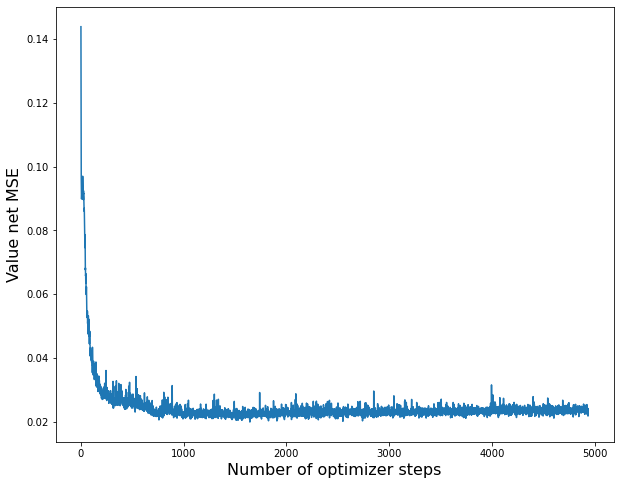

In [7]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Value net MSE", fontsize=16)
plt.show()

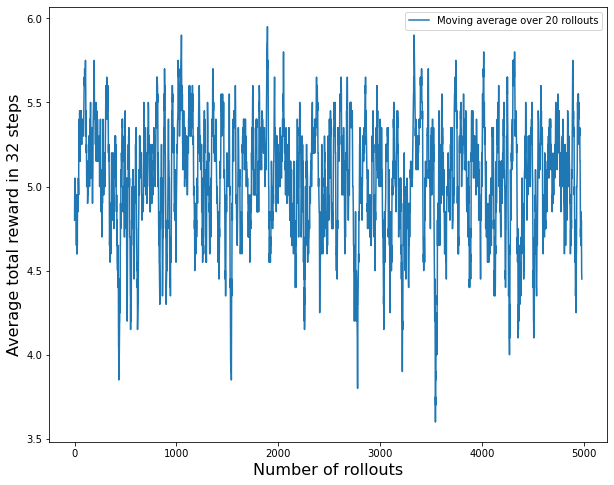

In [8]:
window = 20
average_rewards = np.array([np.mean(total_rewards[i-window:i]) for i in range(window, len(total_rewards))])
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(average_rewards)), average_rewards, label="Moving average over %d rollouts"%window)
plt.xlabel("Number of rollouts", fontsize=16)
plt.ylabel("Average total reward in 32 steps", fontsize=16)
plt.legend()
plt.show()

## Retraining offline to assess undertraining and overfitting issues

In [80]:
%%time
# More thourough test at the end to compare the 3 methods
scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])


Mode: simulate

██████
█    █
█ y n█
█!  @█
█  ? █
██████


██████
█    █
█ y @█
█!   █
█  ? █
██████
shimmering sword

██████
█   @█
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█   @█
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█ @  █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█    █
█ @  █
█!   █
█  ? █
██████
grandmasters sword

██████
█    █
█@   █
█!   █
█  ? █
██████
grandmasters sword

██████
█    █
█    █
█@   █
█  ? █
██████
grandmasters sword

Mode: predict

██████
█    █
█ y n█
█!  @█
█  ? █
██████


██████
█    █
█ y @█
█!   █
█  ? █
██████
shimmering sword

██████
█   @█
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █
██████
shimmering sword

██████
█  @ █
█ y  █
█!   █
█  ? █

## Retraining just the value_net

In [ ]:
skip = False
if not skip:
    # Trying to see retraining it works better
    optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)

    n_updates = 500
    losses = []
    for i in range(n_updates):
        frames, targets = rb.get_batch(64, n_steps, discount, target_net, device)
        values = value_net(frames).squeeze(1)

        loss = loss_fn(values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
        losses.append(loss.item())

In [ ]:
%%time
# More thourough test at the end to compare the 3 methods
scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])

## Updating also the target net

In [ ]:
training_dict = torch.load("saved/training_dict_n_steps_boot_100simul")
object_ids=training_dict["object_ids"]
value_net=training_dict["value_net"]
target_net=training_dict["target_net"]
rb=training_dict["rb"]
losses=training_dict["losses"]

In [ ]:
skip = False
if not skip:
    # Trying to see retraining it works better
    optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)

    n_updates = 500
    losses = []
    for i in range(n_updates):
        frames, targets = rb.get_batch(64, n_steps, discount, target_net, device)
        values = value_net(frames).squeeze(1)

        loss = loss_fn(values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1)%10 == 0:
            train.update_target_net(target_net, value_net, tau)
        print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
        losses.append(loss.item())

In [ ]:
%%time
# More thourough test at the end to compare the 3 methods
scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])

## Cheecking how are the weights of the batch norm layer in the target net

In [61]:
bn = nn.BatchNorm2d(10)
print(bn.running_mean)
print(bn.running_var)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [48]:
for name, weight in target_net.named_parameters():
    batch_norm_names = [
        "conv_net.1.bn1.weight", "conv_net.1.bn1.bias",
        "conv_net.1.bn2.weight", "conv_net.1.bn2.bias",
        "conv_net.2.bn1.weight", "conv_net.2.bn1.bias",
        "conv_net.2.bn2.weight", "conv_net.2.bn2.bias",
    ]
    if name in batch_norm_names:
        print(name, weight)

conv_net.1.bn1.weight Parameter containing:
tensor([0.9750, 0.9816, 0.9995, 1.0049, 0.9922, 1.0192, 1.0583, 0.9916, 0.9805,
        0.9997, 1.0231, 0.9899, 0.9878, 1.0412, 0.9952, 0.9766, 0.9926, 1.0090,
        1.0054, 0.9638, 0.9989, 0.9619, 1.0116, 0.9842, 0.9980, 0.9991, 0.9902,
        1.0036, 0.9769, 0.9973, 0.9960, 0.9798, 0.9841, 0.9868, 1.0163, 1.0031,
        1.0006, 0.9911, 0.9940, 0.9878, 0.9685, 1.0102, 0.9848, 1.0397, 0.9886,
        1.0126, 0.9870, 0.9882, 1.0371, 1.0127, 0.9959, 1.0050, 0.9895, 1.0015,
        0.9842, 0.9972, 0.9854, 1.0143, 0.9914, 1.0135, 1.0035, 0.9872, 0.9973,
        1.0199], device='cuda:0', requires_grad=True)
conv_net.1.bn1.bias Parameter containing:
tensor([-0.0343, -0.0172, -0.0095, -0.0079, -0.0213, -0.0230, -0.0002, -0.0026,
        -0.0252, -0.0013,  0.0105, -0.0099, -0.0186, -0.0051, -0.0217, -0.0402,
        -0.0201, -0.0020, -0.0133, -0.0314,  0.0079, -0.0334,  0.0120, -0.0164,
        -0.0104, -0.0293, -0.0220, -0.0011, -0.0484, -0.0245

In [72]:
for src_module, trg_module in zip(value_net.modules(), target_net.modules()):
    if isinstance(src_module, nn.BatchNorm2d):
        assert isinstance(trg_module, nn.BatchNorm2d), "src_module is instance of  BatchNorm2d but rg_module is not"
        trg_module.running_mean = src_module.running_mean
        trg_module.running_var = src_module.running_var

## Visual graphics for training data - double value net bootstrapping

In [10]:
# Value vs target hist on a batch
target_net.eval()
frames, targets = rb.get_batch(batch_size, n_steps, discount, target_net, device)
targets = targets.reshape(-1).cpu().numpy()
with torch.no_grad():
    value_net.eval()
    trg_values = target_net(frames).flatten().cpu().numpy()
    values = value_net(frames).flatten().cpu().numpy()
diff = values - targets
diff1 = values - trg_values

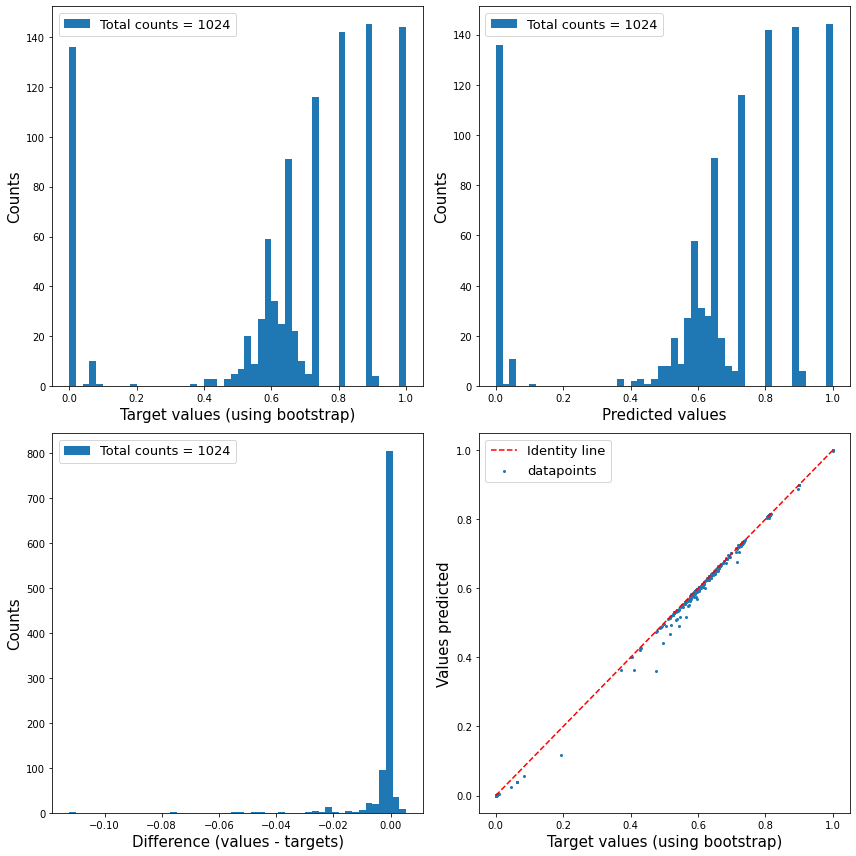

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(trg_values, bins=50, label="Total counts = %d"%len(trg_values))
ax[0,0].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(values, bins=50, label="Total counts = %d"%len(values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff1, bins=50, label="Total counts = %d"%len(diff1))
ax[1,0].set_xlabel("Difference (values - targets)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = trg_values.min(), trg_values.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(trg_values, values, s=4, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

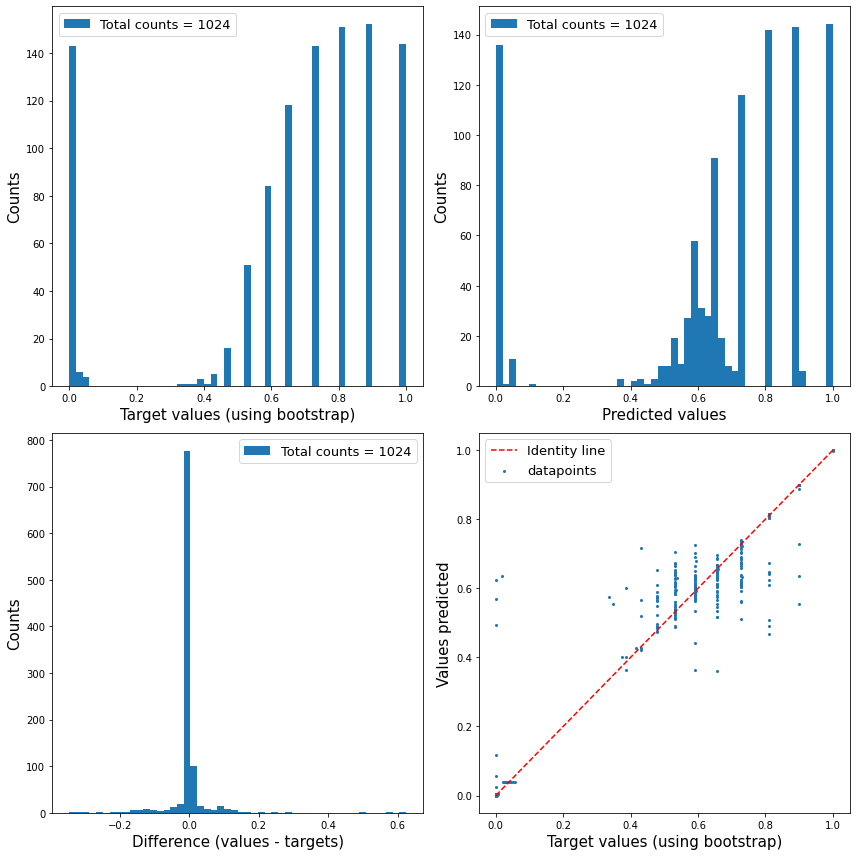

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(targets, bins=50, label="Total counts = %d"%len(targets))
ax[0,0].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(values, bins=50, label="Total counts = %d"%len(values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff, bins=50, label="Total counts = %d"%len(diff))
ax[1,0].set_xlabel("Difference (values - targets)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = targets.min(), targets.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(targets, values, s=4, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

## Visual data on MCTS estimates vs value net ones

In [13]:
def play_rollout_value_net(
        value_net,
        env,
        episode_length,
        ucb_C,
        discount,
        max_actions,
        num_simulations,
        mode="simulate",
        render = False,
        debug_render=False
    ):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    pred_values = []
    root_values = []
    for i in range(episode_length):
        tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        if render:
            print("Performing MCTS step")
        root, info = tree.run(num_simulations, mode=mode)
        pred_value = value_net(root.frame).item()
        #print("pred_value: ", pred_value)
        pred_values.append(pred_value)
        #print("root_value: ", root.value())
        root_values.append(root.value())
        
        if render:
            train.show_root_summary(root, discount)
            print("Tree info: ", info)
        action = root.best_action(discount)
        if render:
            print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        new_root = tree.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        if render:
            env.render()
            print("Reward received: ", reward)
            print("Done: ", done)
        total_reward += reward
        if done:
            frame, valid_actions = env.reset()
            if render:
                print("\nNew episode begins.")
                env.render()
            done = False
            new_root = None

    return pred_values, root_values

In [14]:
episode_length_1 = 200
pred_values, root_values = play_rollout_value_net(value_net,
                                                game_simulator,
                                                episode_length_1,
                                                ucb_C,
                                                discount,
                                                max_actions,
                                                num_simulations,
                                                mode="predict",
                                                )

In [15]:
pred_values = np.array(pred_values)
root_values = np.array(root_values)
diff = pred_values - root_values

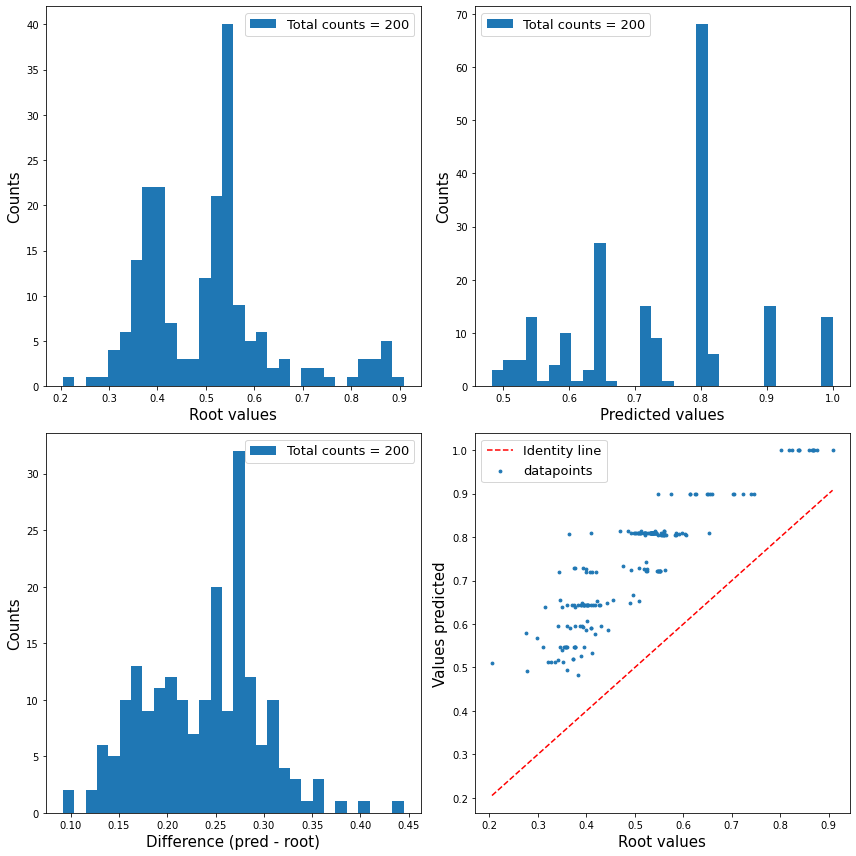

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(root_values, bins=30, label="Total counts = %d"%len(root_values))
ax[0,0].set_xlabel("Root values", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(pred_values, bins=30, label="Total counts = %d"%len(pred_values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff, bins=30, label="Total counts = %d"%len(diff))
ax[1,0].set_xlabel("Difference (pred - root)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = root_values.min(), root_values.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(root_values, pred_values, s=8, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Root values", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

## On-trajectory debug and analysis

In [17]:
verbose = False
vprint = print if verbose else lambda *args, **kwargs: None

In [18]:
action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }

In [19]:
def debug_run(tree, num_simulations, mode="simulate"):
    """
    Runs num_simulations searches starting from the root node corresponding to the internal
    state of the simulator given during initialization.
    Returns the root node and an extra_info dictionary
    """
    if tree.root is None:
        tree.root = mcts.ValueNode()
        tree.root.expand(
            tree.root_frame,
            tree.valid_actions,
            0, # reward to get to root
            False, # terminal node
            tree.simulator # state of the simulator at the root node 
        )
        # not sure about this
        tree.root.visit_count += 1

    max_tree_depth = 0
    root = tree.root
    for n in range(num_simulations):
        ### Start of a simulation/search ###
        vprint("\nSimulation %d started."%(n+1))
        node = root
        # make sure that the simulator internal state is reset to the original one
        tree.simulator.load_state_dict(root.simulator_dict)
        search_path = [node]
        current_tree_depth = 0
        if tree.render:
            node.render(tree.simulator)
        ### Selection phase until leaf node is reached ###
        while node.expanded or (current_tree_depth<self.max_actions):
            current_tree_depth += 1
            action, node = tree.select(node)
            if tree.render and node.expanded:
                node.render(tree.simulator)
            vprint("Current tree depth: ", current_tree_depth)
            vprint("Action selected: %d (%s)"%(action, action_dict[action]))
            vprint("Child node expanded: ", node.expanded)
            if node.expanded:
                vprint("Child node terminal: ", node.terminal)
            if node.expanded or node.terminal:
                search_path.append(node)
                if node.terminal:
                    break
            else:
                break

        ### Expansion of leaf node (if not terminal)###
        vprint("Expansion phase started")
        if not node.terminal:
            parent = search_path[-1] # last expanded node on the search path
            node = tree.expand(node, parent, action)
            if tree.render:
                node.render(tree.simulator)
            search_path.append(node)

        ### Simulation phase for self.max_actions - current_tree_depth steps ###
        vprint("Value prediction/simulation phase started")
        simulated_value = tree.simulate(node, current_tree_depth)
        predicted_value = tree.predict(node)
        if mode == "simulate":
            value = simulated_value
        elif mode == "predict":
            value = predicted_value
        else:
            raise Exception("Unkown mode")
        vprint("Simulated value: ", simulated_value)
        vprint("Predicted value: ", predicted_value)
            
        ### Backpropagation of the leaf node value along the seach_path ###
        vprint("Backpropagation phase started")
        tree.backprop(search_path, value)

        max_tree_depth = max(max_tree_depth, current_tree_depth)
        vprint("Simulation %d done."%(n+1))
    extra_info = {
        "max_tree_depth": max_tree_depth
    }
    # just a check to see if root works as a shallow copy of self.root
    assert root.visit_count == tree.root.visit_count, "self.root not updated during search"

    # make sure that the simulator internal state is reset to the original one
    tree.simulator.load_state_dict(root.simulator_dict)
    return root, extra_info

In [20]:
def play_episode_value_net(
    value_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    mode="simulate",
    render = True,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    reward_lst = []
    done_lst = []
    for i in range(episode_length):
        predict_tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=copy.deepcopy(new_root)
                        )
        simulate_tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=copy.deepcopy(new_root)
                        )
        
        """predict_tree_half = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C/2, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        simulate_tree_half = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C/2, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )"""
        print("Performing MCTS step")
        
        simulate_root, info = debug_run(simulate_tree, num_simulations, mode="simulate")
        print("\nRoot from simulate method")
        train.show_root_summary(simulate_root, discount)
        print("Tree info: ", info)
        
        #if new_root is not None:
        #    print("new_root.visit_count (after first debug run):", new_root.visit_count)
        
        predict_root, info = debug_run(predict_tree, num_simulations, mode="predict")
        print("\nRoot from predict method")
        train.show_root_summary(predict_root, discount)
        print("Tree info: ", info)
        
        """predict_root_half, info = debug_run(predict_tree_half, num_simulations, mode="predict")
        print("\nRoot from predict method (half C)")
        mcts.show_root_summary(predict_root_half, discount)
        print("Tree info: ", info)
        
        simulate_root_half, info = debug_run(simulate_tree_half, num_simulations, mode="simulate")
        print("\nRoot from simulate method (half C)")
        mcts.show_root_summary(simulate_root_half, discount)
        print("Tree info: ", info)"""
        
        root = predict_root
        tree = predict_tree
        
        action = root.best_action(discount)
        print("\nWith predict method we select: ", action, "({})".format(action_dict[action]))
        simulate_action = simulate_root.best_action(discount)
        print("With simulate method we would select: ", simulate_action, "({})".format(action_dict[simulate_action]))
        #half_a_sim = simulate_root_half.best_action(discount)
        #print("With simulate (half C) method we select: ", half_a_sim, "({})".format(action_dict[half_a_sim]))
        #half_a_pred = predict_root_half.best_action(discount)
        #print("With predict (half C) method we would select: ", half_a_pred, "({})".format(action_dict[half_a_pred]))
        new_root = tree.get_subtree(action)
        #print("new_root.visit_count", new_root.visit_count)
        #ew_root = None ### Pay attention to this !! 
        frame, valid_actions, reward, done = env.step(action)
        
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
        #print("Reward received: ", reward)
        #print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward, frame_lst, reward_lst, done_lst

In [21]:
import train

In [22]:
%%time
num_simulations = 50
total_reward, frame_lst, reward_lst, done_lst = play_episode_value_net(value_net,
                                                                        game_simulator,
                                                                        episode_length,
                                                                        ucb_C,
                                                                        discount,
                                                                        max_actions,
                                                                        num_simulations,
                                                                        mode="predict",
                                                                        render=True
                                                                        )


██████
█    █
█y !?█
█   n█
█  @ █
██████

Performing MCTS step

Root from simulate method
Action  Stay : Q-value=-0.051 - Visit counts=16
Action  Up : Q-value=-0.155 - Visit counts=11
Action  Left : Q-value=-0.107 - Visit counts=13
Action  Right : Q-value=-0.211 - Visit counts=10
Tree info:  {'max_tree_depth': 4}

Root from predict method
Action  Stay : Q-value=0.461 - Visit counts=13
Action  Up : Q-value=0.350 - Visit counts=9
Action  Left : Q-value=0.519 - Visit counts=17
Action  Right : Q-value=0.419 - Visit counts=11
Tree info:  {'max_tree_depth': 3}

With predict method we select:  3 (Left)
With simulate method we would select:  0 (Stay)

██████
█    █
█y !?█
█   n█
█ @  █
██████

Performing MCTS step

Root from simulate method
Action  Stay : Q-value=0.087 - Visit counts=18
Action  Up : Q-value=0.016 - Visit counts=13
Action  Left : Q-value=0.122 - Visit counts=20
Action  Right : Q-value=0.037 - Visit counts=15
Tree info:  {'max_tree_depth': 4}

Root from predict method
Action  

## Analysing the value net based on some states

Note: is important to save and load the gym_env with which the network has been trained, because otherwise there might be different objects to the one seen in the training set.

In [23]:
def distance_from_target(name_frame):
    try:
        y_a, x_a = torch.nonzero(name_frame[:,:,0,0] == object_ids["agent"])[0]
        y_t, x_t = torch.nonzero(name_frame[:,:,0,0] == object_ids["target_monster"])[0]
        d = torch.abs(y_a - y_t) + torch.abs(x_a - x_t)
        return d
    except:
        return None

In [24]:
def render_frame(name_frame, object_ids):
    wall_ids = 3
    
    W = H = name_frame.shape[0]
    empty_row = [" " for _ in range(W)]
    representation = np.array([empty_row for _ in range(H)])
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["agent"])[0]
        representation[y, x] = "@"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["target_monster"])[0]
        representation[y, x] = "!"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["distractor_monster"])[0]
        representation[y, x] = "?"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["yes_item"])[0]
        representation[y, x] = "y"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["no_item"])[0]
        representation[y, x] = "n"
    except:
        pass

    try:
        positions = torch.nonzero(name_frame[:,:,0,0] == wall_ids)
        for y,x in positions:
            representation[y, x] = u"\u2588"
    except:
        pass
    
    char_repr = ""
    for r in representation:
        for r_i in r:
            char_repr += r_i
        char_repr +="\n"
    print(char_repr)

In [25]:
def analyse_d_states(frames, distances, d, object_ids, render=True):
    mask = (distances == d)
    states = frames["name"][mask]
    inventories = frames["inv"][mask]
    
    empty_inv = []
    yes_inv = []
    no_inv = []
    for i, f in enumerate(states):
        if render:
            print("\n\n")
            render_frame(f, object_ids)
        inv = inventories[i,0]
        if inv == 0:
            empty_inv.append(i)
            if render:
                print("Inv: empty")
        if inv == object_ids["yes_item"]:
            yes_inv.append(i)
            if render:
                print("Inv: yes item")
        if inv == object_ids["no_item"]:
            no_inv.append(i)
            if render:
                print("Inv: no item")
                
    empty_inv = np.array(empty_inv)
    yes_inv = np.array(yes_inv)
    no_inv = np.array(no_inv)
    inv_dict = dict(empty_inv=empty_inv, yes_inv=yes_inv, no_inv=no_inv)
    return states, inventories, mask, inv_dict

In [26]:
def render_states(states, values, targets, inv_dict, object_ids, render=False):
    means = {}
    devs = {}
    
    empty_inv_states = states[inv_dict["empty_inv"]]
    empty_inv_values = values[inv_dict["empty_inv"]]
    empty_inv_targets = targets[inv_dict["empty_inv"]]
    means["empty_values"] = empty_inv_values.mean()
    means["empty_targets"] = empty_inv_targets.mean()
    devs["empty_values"] = empty_inv_values.std()
    devs["empty_targets"] = empty_inv_targets.std()
    
    print("Rendering states with empty inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["empty_values"],devs["empty_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["empty_targets"],devs["empty_targets"]))
    if render:
        for i, s in enumerate(empty_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: empty")
            print("Predicted value: %.4f"%empty_inv_values[i])
            print("Target value:    %.4f"%empty_inv_targets[i])
    print("-"*40)
    
    yes_inv_states = states[inv_dict["yes_inv"]]
    yes_inv_values = values[inv_dict["yes_inv"]]
    yes_inv_targets = targets[inv_dict["yes_inv"]]
    means["yes_values"] = yes_inv_values.mean()
    means["yes_targets"] = yes_inv_targets.mean()
    devs["yes_values"] = yes_inv_values.std()
    devs["yes_targets"] = yes_inv_targets.std()
    
    print("Rendering states with correct item in inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["yes_values"],devs["yes_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["yes_targets"],devs["yes_targets"]))
    if render:
        for i, s in enumerate(yes_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: yes item")
            print("Predicted value: %.4f"%yes_inv_values[i])
            print("Target value:    %.4f"%yes_inv_targets[i])
    print("-"*40)
    
    no_inv_states = states[inv_dict["no_inv"]]
    no_inv_values = values[inv_dict["no_inv"]]
    no_inv_targets = targets[inv_dict["no_inv"]]
    means["no_values"] = no_inv_values.mean()
    means["no_targets"] = no_inv_targets.mean()
    devs["no_values"] = no_inv_values.std()
    devs["no_targets"] = no_inv_targets.std()
    
    print("Rendering states with wrong item in inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["no_values"],devs["no_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["no_targets"],devs["no_targets"]))
    if render:
        for i, s in enumerate(no_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: no item")
            print("Predicted value: %.4f"%no_inv_values[i])
            print("Target value:    %.4f"%no_inv_targets[i])
    print("-"*40)
    
    return means, devs

In [29]:
def full_distance_analysis(frames, targets, value_net, distance, object_ids):

    distances = []
    for t in range(len(frames["name"])):
        d = distance_from_target(frames["name"][t])
        if d is None:
            d = torch.tensor([0.]).float()
        else:
            d = torch.tensor([d]).float()
        distances.append(d)
    distances = torch.cat(distances, axis=0)

    targets = targets.reshape(-1).cpu().numpy()

    states, inventories, mask, inv_dict = analyse_d_states(frames, distances, distance, object_ids, render=False)
    masked_target = targets[mask]
    masked_frames = {}
    for k in frames.keys():
        masked_frames[k] = frames[k][mask]
    with torch.no_grad():
        masked_values = value_net(masked_frames).flatten().cpu().numpy()
    means, devs = render_states(states, masked_values, masked_target, inv_dict, object_ids)
    return means, devs

In [30]:
frames, targets = rb.get_batch(256, n_steps, discount, target_net, device)
value_means = np.zeros((5, 3))
value_devs = np.zeros((5, 3))
target_means = np.zeros((5, 3))
target_devs = np.zeros((5, 3))

for distance in range(0,5):
    print("\nDistance from target: ", distance+1)
    means, devs = full_distance_analysis(frames, targets, value_net, distance+1, object_ids)
    
    value_means[distance,0] = means["empty_values"]
    value_means[distance,1] = means["yes_values"]
    value_means[distance,2] = means["no_values"]
    target_means[distance,0] = means["empty_targets"]
    target_means[distance,1] = means["yes_targets"]
    target_means[distance,2] = means["no_targets"]
    value_devs[distance,0] = devs["empty_values"]
    value_devs[distance,1] = devs["yes_values"]
    value_devs[distance,2] = devs["no_values"]
    target_devs[distance,0] = devs["empty_targets"]
    target_devs[distance,1] = devs["yes_targets"]
    target_devs[distance,2] = devs["no_targets"]



Distance from target:  1
Rendering states with empty inventory
Mean predicted value: 0.44 +/- 0.35
Mean target value: 0.44 +/- 0.36
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 1.00 +/- 0.00
Mean target value: 1.00 +/- 0.00
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.74 +/- 0.10
Mean target value: 0.74 +/- 0.10
----------------------------------------

Distance from target:  2
Rendering states with empty inventory
Mean predicted value: 0.61 +/- 0.28
Mean target value: 0.61 +/- 0.28
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 0.86 +/- 0.18
Mean target value: 0.86 +/- 0.18
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.74 +/- 0.12
Mean target value: 0.74 +/- 0.12
----------------------------------------

Distance from target:  

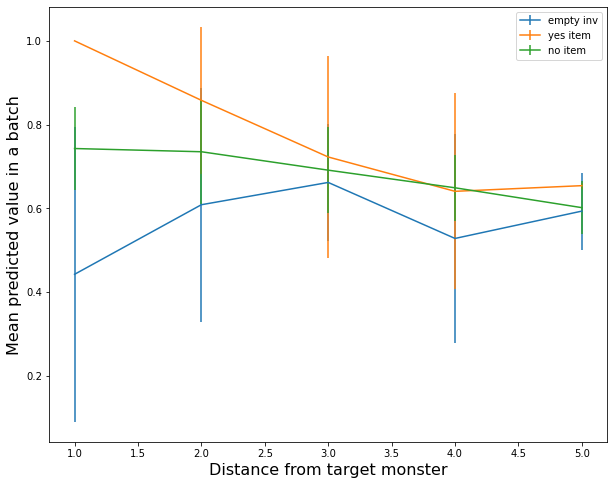

In [31]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, value_means[:,0], yerr=value_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, value_means[:,1], yerr=value_devs[:,1], label="yes item")
plt.errorbar(possible_distances, value_means[:,2], yerr=value_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean predicted value in a batch", fontsize=16)
plt.legend()
plt.show()

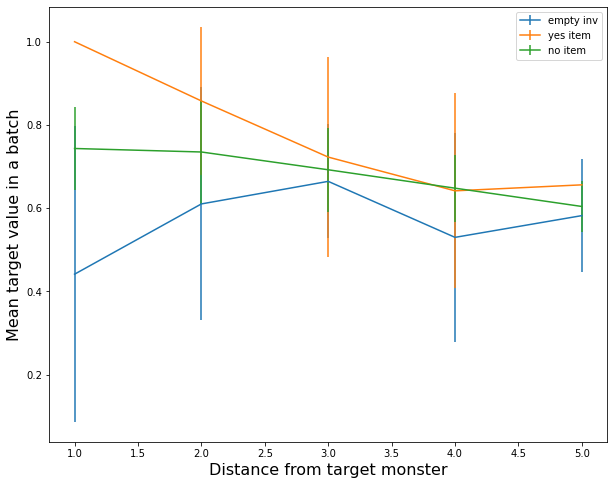

In [32]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, target_means[:,0], yerr=target_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, target_means[:,1], yerr=target_devs[:,1], label="yes item")
plt.errorbar(possible_distances, target_means[:,2], yerr=target_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean target value in a batch", fontsize=16)
plt.legend()
plt.show()

## Value map on hand-designed frames

In [33]:
class FrameGenerator:
    def __init__(self, object_ids, example_frame):
        self.wall_id = 3
        self.free_cell_id = 170
        self.empty_slot_id = 0
        self.object_ids = object_ids
        self.wall_mask = (example_frame["name"][0,:,:,0,0]==self.wall_id)
        self.frame_shape = example_frame["name"].shape
        self.inv_shape = example_frame["inv"].shape
        self.canvas = self.generate_canvas()
        
    def generate_frame(self, agent_pos=None, target_pos=None, distractor_pos=None, yes_pos=None, no_pos=None):
        frame = copy.deepcopy(self.canvas)
        if agent_pos is not None:
            x,y = agent_pos
            frame["name"][0,x,y,0,0] = object_ids["agent"]
        
        if target_pos is not None:
            x,y = target_pos
            frame["name"][0,x,y,0,0] = object_ids["target_monster"]
        
        if distractor_pos is not None:
            x,y = distractor_pos
            frame["name"][0,x,y,0,0] = object_ids["distractor_monster"]
        
        if yes_pos is not None:
            if yes_pos == "inv":
                frame["inv"][0,0] = object_ids["yes_item"] 
            else:
                x,y = yes_pos
                frame["name"][0,x,y,0,0] = object_ids["yes_item"]
        
        if no_pos is not None:
            if no_pos == "inv":
                frame["inv"][0,0] = object_ids["no_item"] 
            else:
                x,y = no_pos
                frame["name"][0,x,y,0,0] = object_ids["no_item"]
    
        return frame
    
    def generate_canvas(self):
        frame = torch.zeros(self.frame_shape).long()
        inv = torch.zeros(self.inv_shape).long()
        frame[0,:,:,0,0] = 170
        frame[0,:,:,1,0] = 170
        frame[0,:,:,0,0][self.wall_mask] = self.wall_id
        canvas = {"name":frame,"inv":inv}
        return canvas

In [34]:
ID = "optimal_value_AAE"
checkpoint="5000"
#training_dict = torch.load("saved/"+ID+checkpoint)
training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID,checkpoint))
try:
    episodes_played = training_dict["episodes_played"]
    training_params = training_dict["training_params"]
    total_rewards = training_dict["total_rewards"]
except:
    pass

object_ids=training_dict["object_ids"]
value_net=training_dict["value_net"]
target_net=training_dict["target_net"]
rb=training_dict["rb"]
losses=training_dict["losses"]

In [35]:
frame, _ = game_simulator.reset()
fg = FrameGenerator(object_ids, frame)

### Possible frames to test

1. Only agent and target, while having yes item in the inventory; Pick random target position, generate a frame for every possible position the agent can occupy. Do that for different target positions. (Q: does the agent correctly identifies the states near the target as the highest in value given the circumstances?)

2. Agent, target and yes item on the map still to be collected. Same idea. (Q: does the agent correctly identifies the states near the item as the highest in value given the circumstances?)

3. Agent, target and distractor, while having yes item in the inventory. (Q: does the distractor influences the trajectory that the agent would take to go to the target?)

4. Agent, target, distractor and yes item still on the map. (Q: does the distractor influences the trajectory that the agent would take to go to the yes item?)

5. Everything on the map, nothing on the inventory. (Q: does the agent goes for the yes item? Would it deviate along the way to collect the no item?)  

# 1 Map: agent, target. Inv: yes item

In [36]:
def agent_target_yes_item_in_inv_frames(frame_generator):
    free_positions = list(torch.nonzero((~frame_generator.wall_mask).float()))
    idx = np.random.choice(len(free_positions))
    
    target_pos = free_positions.pop(idx)
    
    frames = []
    for agent_pos in free_positions:
        frame = frame_generator.generate_frame(agent_pos, target_pos, yes_pos="inv")
        frames.append(frame)
        
    return frames, target_pos, free_positions

In [37]:
def render_value_map_yes_inv(frame_generator, value_net, object_ids):
    frames, target_pos, free_positions = agent_target_yes_item_in_inv_frames(frame_generator)
    values = []
    for f in frames:
        with torch.no_grad():
            v = value_net(f).cpu().item()
            values.append(v)
    values = np.array(values)
    
    print("\nExample of frame:")
    render_frame(frames[0]["name"][0], object_ids)
    value_map = np.zeros(frame_generator.wall_mask.shape)
    #value_map[target_pos[0], target_pos[1]] = 0.
    for i, agent_pos in enumerate(free_positions):
        value_map[agent_pos[0],agent_pos[1]] = values[i]
    
    plt.imshow(value_map, cmap="copper")
    plt.title("Yes item in inventory \nTarget position: (row=%d,col=%d)"%(target_pos[0],target_pos[1]))
    plt.colorbar()
    plt.show()
    
    print("NOTE: value corresponding to target position and walls set to 0 as a default.")


Example of frame:
██████
█@   █
█    █
█    █
█  ! █
██████



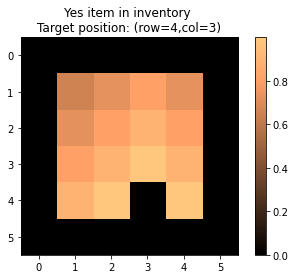

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█    █
█!   █
██████



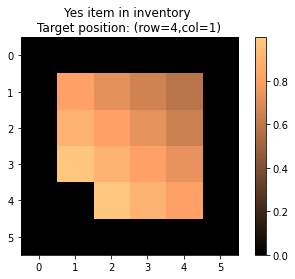

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█   !█
█    █
█    █
██████



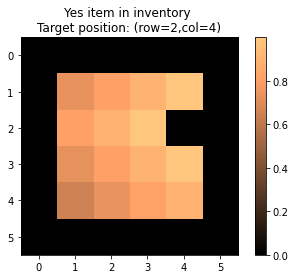

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█!   █
█    █
█    █
██████



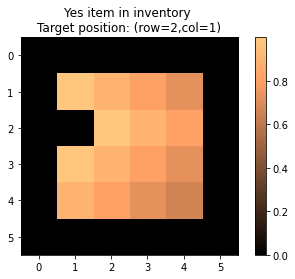

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█  ! █
█    █
█    █
██████



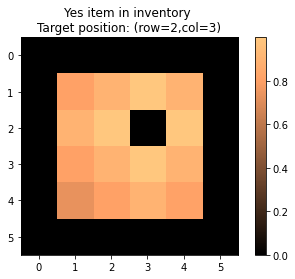

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█!   █
█    █
██████



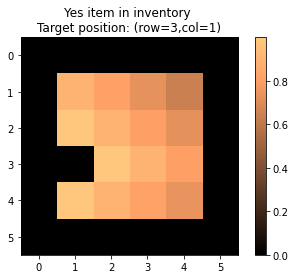

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█!   █
█    █
██████



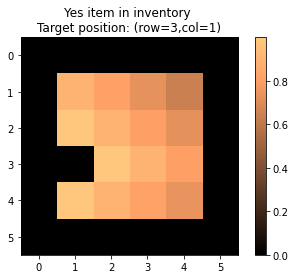

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█ !  █
█    █
██████



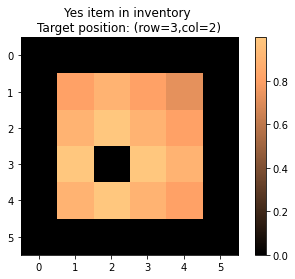

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@ ! █
█    █
█    █
█    █
██████



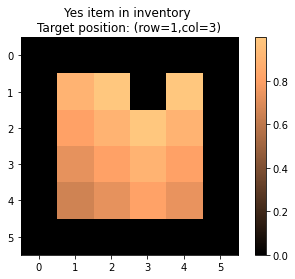

NOTE: value corresponding to target position and walls set to 0 as a default.

Example of frame:
██████
█@!  █
█    █
█    █
█    █
██████



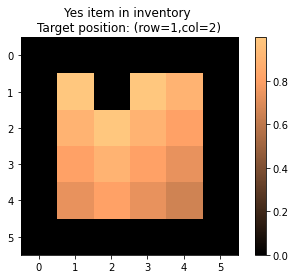

NOTE: value corresponding to target position and walls set to 0 as a default.


In [38]:
for i in range(10):
    render_value_map_yes_inv(fg, value_net, object_ids)

# 2 Map: agent, target, yes item. Inv: empty

In [39]:
def agent_target_yes_item_to_collect_frames(frame_generator):
    free_positions = list(torch.nonzero((~frame_generator.wall_mask).float()))
    
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)
    
    frames = []
    for agent_pos in free_positions:
        frame = frame_generator.generate_frame(agent_pos, target_pos, yes_pos=yes_pos)
        frames.append(frame)
        
    return frames, target_pos, yes_pos, free_positions

In [40]:
def render_value_map_yes_to_collect(frame_generator, value_net, object_ids):
    frames, target_pos, yes_pos, free_positions = agent_target_yes_item_to_collect_frames(frame_generator)
    values = []
    for f in frames:
        with torch.no_grad():
            v = value_net(f).cpu().item()
            values.append(v)
    values = np.array(values)
    
    print("\nExample of frame:")
    render_frame(frames[0]["name"][0], object_ids)
    value_map = np.zeros(frame_generator.wall_mask.shape)
    #value_map[target_pos[0], target_pos[1]] = -1.
    for i, agent_pos in enumerate(free_positions):
        value_map[agent_pos[0],agent_pos[1]] = values[i]
    plt.imshow(value_map, cmap="copper")
    x1, y1 = yes_pos
    x2, y2 = target_pos
    plt.title("Yes item position: (row=%d,col=%d) \nTarget position: (row=%d,col=%d)"%(x1,y1,x2,y2))
    plt.colorbar()
    plt.show()
    
    print("NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.")


Example of frame:
██████
█!@  █
█y   █
█    █
█    █
██████



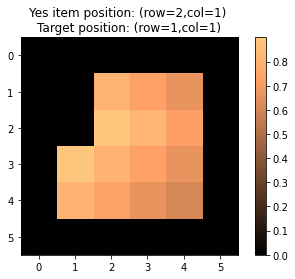

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█y ! █
█    █
█    █
██████



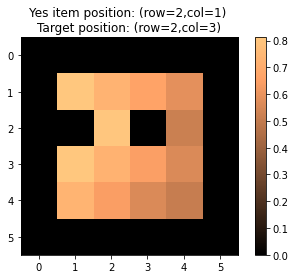

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@ y █
█    █
█   !█
█    █
██████



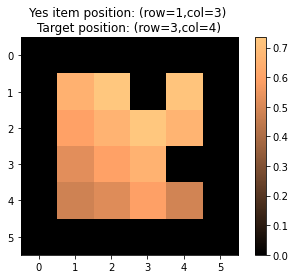

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█y  !█
█    █
█    █
██████



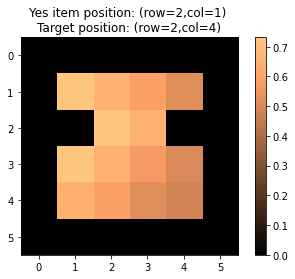

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█ !  █
█ y  █
█    █
██████



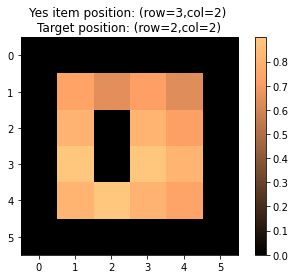

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@ y!█
█    █
█    █
█    █
██████



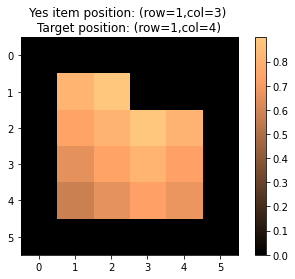

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█y@  █
█    █
█ !  █
█    █
██████



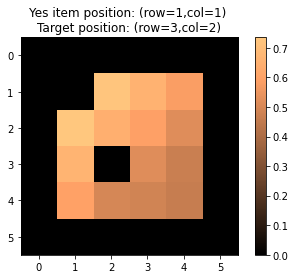

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█ ! y█
█    █
█    █
██████



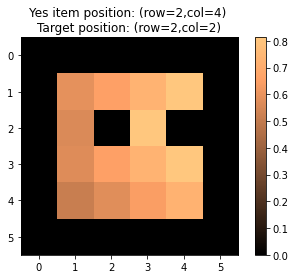

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█  y █
█ !  █
██████



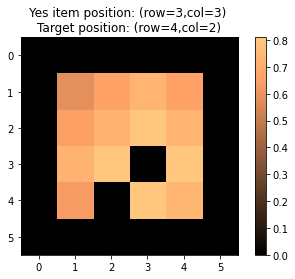

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.

Example of frame:
██████
█@   █
█  y █
█    █
█!   █
██████



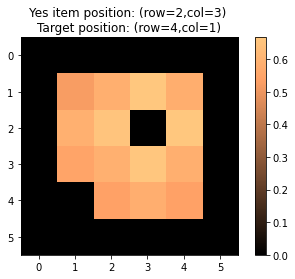

NOTE: value corresponding to target position, yes item position and walls set to 0 as a default.


In [41]:
for i in range(10):
    render_value_map_yes_to_collect(fg, value_net, object_ids)

# 3 Map: agent, target, distractor - Inv: yes item

In [42]:
def third_scenario_frames(frame_generator):
    free_positions = list(torch.nonzero((~frame_generator.wall_mask).float()))
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    frames = []
    for agent_pos in free_positions:
        frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos="inv")
        frames.append(frame)
        
    return frames, target_pos, distractor_pos, free_positions

In [43]:
def render_value_map_third_scenario(frame_generator, value_net, object_ids):
    frames, target_pos, distractor_pos, free_positions = third_scenario_frames(frame_generator)
    values = []
    for f in frames:
        with torch.no_grad():
            v = value_net(f).cpu().item()
            values.append(v)
    values = np.array(values)
    
    print("\nExample of frame:")
    render_frame(frames[0]["name"][0], object_ids)
    value_map = np.zeros(frame_generator.wall_mask.shape)
    #value_map[target_pos[0], target_pos[1]] = -1.
    for i, agent_pos in enumerate(free_positions):
        value_map[agent_pos[0],agent_pos[1]] = values[i]
    plt.imshow(value_map, cmap="copper")
    
    x1, y1 = target_pos
    x2, y2 = distractor_pos
    title1 = "Yes item in inventory"
    title2 = "\nTarget position: (row=%d,col=%d)"%(x1,y1)
    title3 = "\nDistractor position: (row=%d,col=%d)"%(x2,y2)
    
    plt.title( title1+title2+title3)
    plt.colorbar()
    plt.show()
    
    print("NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.")


Example of frame:
██████
█?@  █
█    █
█    █
█   !█
██████



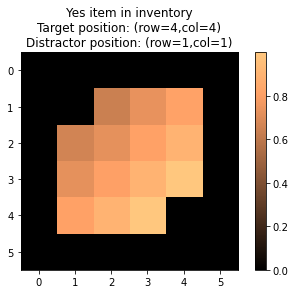

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@  !█
█    █
█    █
█?   █
██████



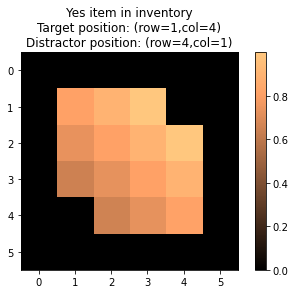

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█  ? █
█   !█
██████



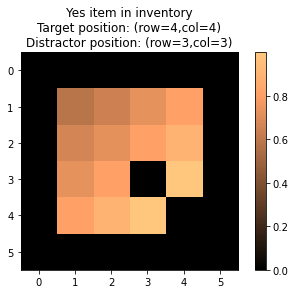

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ ? █
█    █
█    █
█   !█
██████



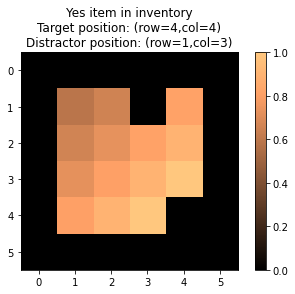

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@!  █
█?   █
█    █
█    █
██████



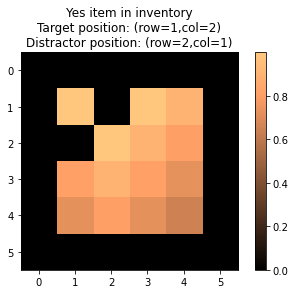

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█ !  █
█  ? █
█    █
██████



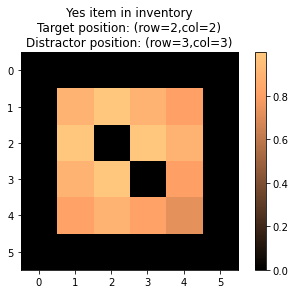

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█ !? █
█    █
█    █
██████



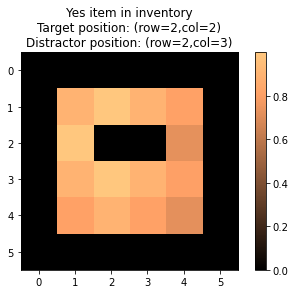

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█   ?█
█ !  █
██████



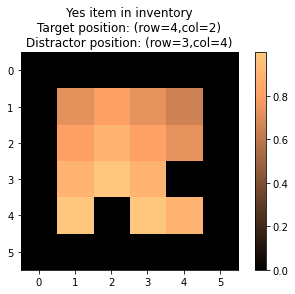

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█!@  █
█?   █
█    █
█    █
██████



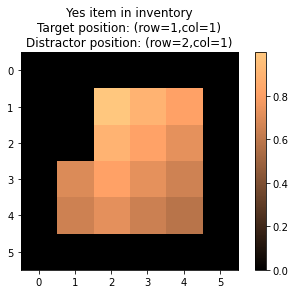

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@  !█
█    █
█   ?█
█    █
██████



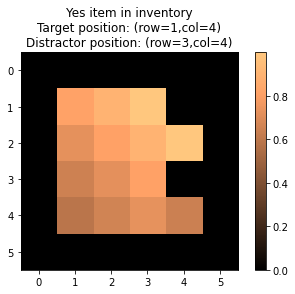

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.


In [44]:
for i in range(10):
    render_value_map_third_scenario(fg, value_net, object_ids)

# 4 Map: agent, target, distractor, yes item - Inv: empty

In [45]:
def fourth_scenario_frames(frame_generator):
    free_positions = list(torch.nonzero((~frame_generator.wall_mask).float()))
    
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
   
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)
    
    frames = []
    for agent_pos in free_positions:
        frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos)
        frames.append(frame)
        
    return frames, target_pos, distractor_pos, yes_pos, free_positions

In [46]:
def render_value_map_fourth_scenario(frame_generator, value_net, object_ids):
    frames, target_pos, distractor_pos, yes_pos, free_positions = fourth_scenario_frames(frame_generator)
    values = []
    for f in frames:
        with torch.no_grad():
            v = value_net(f).cpu().item()
            values.append(v)
    values = np.array(values)
    
    print("\nExample of frame:")
    render_frame(frames[0]["name"][0], object_ids)
    value_map = np.zeros(frame_generator.wall_mask.shape)
    #value_map[target_pos[0], target_pos[1]] = -1.
    for i, agent_pos in enumerate(free_positions):
        value_map[agent_pos[0],agent_pos[1]] = values[i]
    plt.imshow(value_map, cmap="copper")
    
    x1, y1 = yes_pos
    x2, y2 = target_pos
    x3, y3 = distractor_pos
    title1 = "Yes item position: (row=%d,col=%d)"%(x1,y1)
    title2 = "\nTarget position: (row=%d,col=%d)"%(x2,y2)
    title3 = "\nDistractor position: (row=%d,col=%d)"%(x3,y3)
    
    plt.title( title1+title2+title3)
    plt.colorbar()
    plt.show()
    
    print("NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.")


Example of frame:
██████
█@  y█
█    █
█ !  █
█  ? █
██████



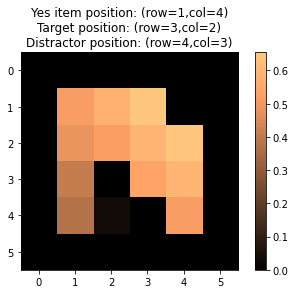

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█    █
█y!  █
█  ? █
██████



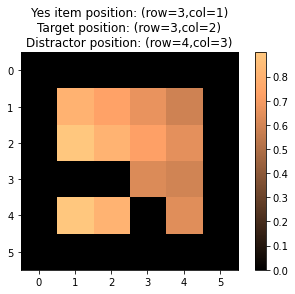

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█  ! █
█  ? █
█ y  █
██████



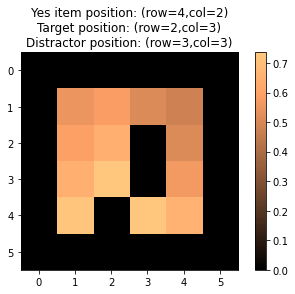

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@y? █
█    █
█!   █
█    █
██████



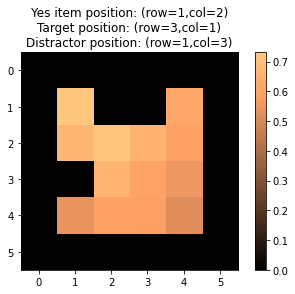

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█  ? █
█  y █
█ !  █
██████



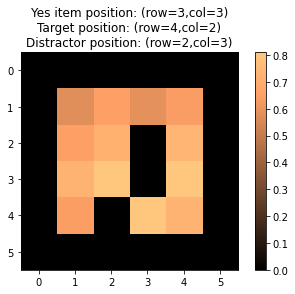

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@!  █
█    █
█   ?█
█   y█
██████



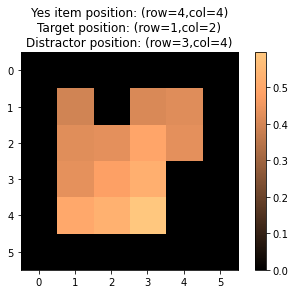

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ ! █
█? y █
█    █
█    █
██████



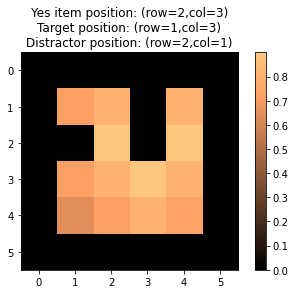

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@!  █
█    █
█ ?  █
█  y █
██████



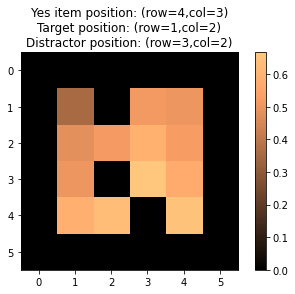

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ ! █
█  ? █
█ y  █
█    █
██████



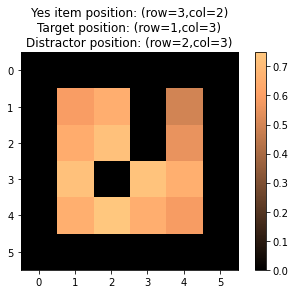

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█!@  █
█    █
█?  y█
█    █
██████



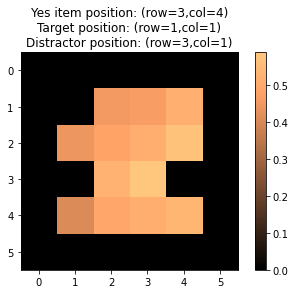

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.


In [47]:
for i in range(10):
    render_value_map_fourth_scenario(fg, value_net, object_ids)

# 5 Map: all - Inv: empty

In [48]:
def fifth_scenario_frames(frame_generator):
    free_positions = list(torch.nonzero((~frame_generator.wall_mask).float()))
    
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
   
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    
    no_pos = free_positions.pop(idx)
    
    frames = []
    for agent_pos in free_positions:
        frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos, no_pos)
        frames.append(frame)
        
    return frames, target_pos, distractor_pos, yes_pos, no_pos, free_positions

In [49]:
def render_value_map_fifth_scenario(frame_generator, value_net, object_ids):
    frames, target_pos, distractor_pos, yes_pos, no_pos, free_positions = fifth_scenario_frames(frame_generator)
    values = []
    for f in frames:
        with torch.no_grad():
            v = value_net(f).cpu().item()
            values.append(v)
    values = np.array(values)
    
    print("\nExample of frame:")
    render_frame(frames[0]["name"][0], object_ids)
    value_map = np.zeros(frame_generator.wall_mask.shape)
    #value_map[target_pos[0], target_pos[1]] = -1.
    for i, agent_pos in enumerate(free_positions):
        value_map[agent_pos[0],agent_pos[1]] = values[i]
    plt.imshow(value_map, cmap="copper")
    plt.colorbar()
    plt.show()
    
    print("NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.")


Example of frame:
██████
█@ ? █
█  y █
█ n !█
█    █
██████



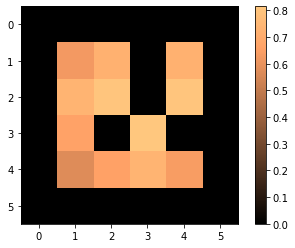

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ !n█
█ y  █
█    █
█?   █
██████



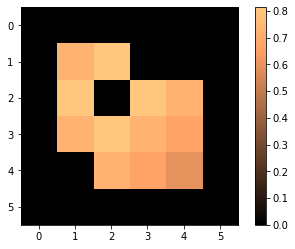

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@  ?█
█  n █
█  ! █
█y   █
██████



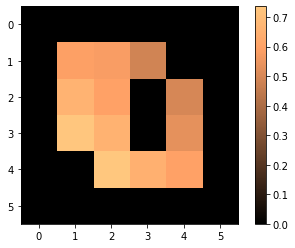

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█ !n █
█   ?█
█ y  █
██████



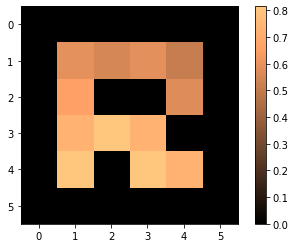

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█   n█
█ ! y█
█?   █
██████



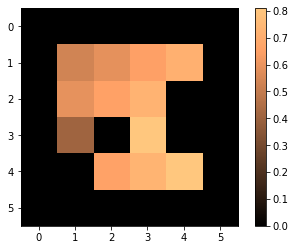

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ n █
█    █
█y   █
█ ? !█
██████



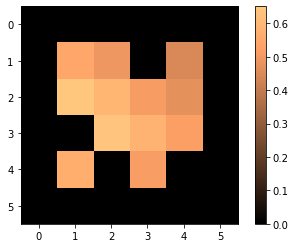

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@?y █
█n   █
█  ! █
█    █
██████



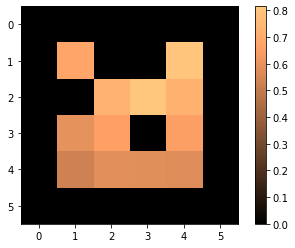

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@   █
█  ! █
█ ?  █
█  yn█
██████



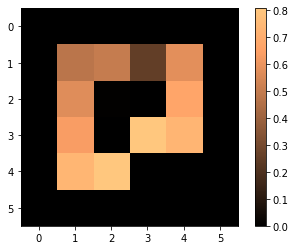

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█?@  █
█    █
█y n █
█  ! █
██████



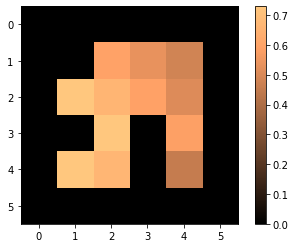

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.

Example of frame:
██████
█@ y █
█    █
█    █
█n ?!█
██████



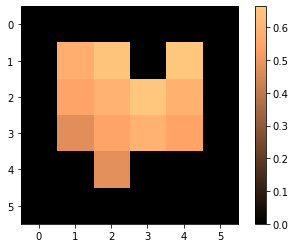

NOTE: value corresponding to target and distractor positions and walls set to 0 as a default.


In [50]:
for i in range(10):
    render_value_map_fifth_scenario(fg, value_net, object_ids)

## Will the agent pick the item if it has it nearby?

Cases to look at
1. Value of being adjacent to the yes item vs value of being on the cell previously occupied by the yes item with that item in the inventory
2. Same thing but with 2 steps of distance 
3. From 2 steps away to a signle step away from the yes item

Notes:
- Generate also everything else as a random element in the map. 

In [51]:
frame, _ = game_simulator.reset()
fg = FrameGenerator(object_ids, frame)

## Pick yes item from one cell away

In [52]:
def pick_yes_one_step_frames(frame_generator):
    free_positions = list(torch.nonzero((~fg.wall_mask).float()))
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)


    distances = torch.tensor([(pos-yes_pos).abs().sum() for pos in free_positions])
    near_indexes = torch.arange(len(free_positions))[distances == 1]
    agent_idx = np.random.choice(near_indexes.cpu().numpy())
    agent_pos = free_positions.pop(agent_idx)

        
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
   
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    no_pos = free_positions.pop(idx)
    
    start_frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos, no_pos)
    end_frame = frame_generator.generate_frame(yes_pos, target_pos, distractor_pos, "inv", no_pos)
    return start_frame, end_frame

In [53]:
correct_eval = []
for i in range(1000):
    start_frame, end_frame = pick_yes_one_step_frames(fg)
    start_value = value_net(start_frame).item()
    end_value = value_net(end_frame).item()
    if end_value > start_value:
        correct_eval.append(True)
    else:
        correct_eval.append(False)
        
    if i==0:
        print("\nStarting frame:")
        render_frame(start_frame["name"][0], object_ids)
        print("Inventory: ", start_frame["inv"])
        print("Value: %.3f"%start_value)

        print("\nEnd frame:")
        render_frame(end_frame["name"][0], object_ids)
        print("Inventory: ", end_frame["inv"])
        print("Value: %.3f"%end_value)
        
avg_correct_eval = np.array(correct_eval, dtype=np.float).mean()
print("Percentage of correct evaluations: %.1f"%(avg_correct_eval*100))


Starting frame:
██████
█   !█
█  n █
█? y █
█  @ █
██████

Inventory:  tensor([[0, 0]])
Value: 0.728

End frame:
██████
█   !█
█  n █
█? @ █
█    █
██████

Inventory:  tensor([[199,   0]])
Value: 0.807
Percentage of correct evaluations: 98.8


## Better evaluation after picking yes item 2 cells away

In [54]:
def pick_yes_two_steps_frames(frame_generator):
    free_positions = list(torch.nonzero((~fg.wall_mask).float()))
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)


    distances = torch.tensor([(pos-yes_pos).abs().sum() for pos in free_positions])
    near_indexes = torch.arange(len(free_positions))[distances == 2]
    agent_idx = np.random.choice(near_indexes.cpu().numpy())
    agent_pos = free_positions.pop(agent_idx)

        
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
   
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    no_pos = free_positions.pop(idx)
    
    start_frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos, no_pos)
    end_frame = frame_generator.generate_frame(yes_pos, target_pos, distractor_pos, "inv", no_pos)
    return start_frame, end_frame

In [55]:
correct_eval = []
for i in range(1000):
    start_frame, end_frame = pick_yes_two_steps_frames(fg)
    start_value = value_net(start_frame).item()
    end_value = value_net(end_frame).item()
    if end_value > start_value:
        correct_eval.append(True)
    else:
        correct_eval.append(False)
        
    if i==0:
        print("\nStarting frame:")
        render_frame(start_frame["name"][0], object_ids)
        print("Inventory: ", start_frame["inv"])
        print("Value: %.3f"%start_value)

        print("\nEnd frame:")
        render_frame(end_frame["name"][0], object_ids)
        print("Inventory: ", end_frame["inv"])
        print("Value: %.3f"%end_value)
        
avg_correct_eval = np.array(correct_eval, dtype=np.float).mean()
print("Percentage of correct evaluations: %.1f"%(avg_correct_eval*100))


Starting frame:
██████
█y?  █
█    █
█@  n█
█  ! █
██████

Inventory:  tensor([[0, 0]])
Value: 0.533

End frame:
██████
█@?  █
█    █
█   n█
█  ! █
██████

Inventory:  tensor([[199,   0]])
Value: 0.663
Percentage of correct evaluations: 99.0


## Go towards yes item if n steps away (clear path available)

In [56]:
def n_to_one_steps_frames(frame_generator, n_steps=2):
    free_positions = list(torch.nonzero((~fg.wall_mask).float()))
    idx = np.random.choice(len(free_positions))
    yes_pos = free_positions.pop(idx)


    distances = torch.tensor([(pos-yes_pos).abs().sum() for pos in free_positions])
    near_indexes = torch.arange(len(free_positions))[distances == n_steps]
    agent_idx = np.random.choice(near_indexes.cpu().numpy())
    agent_pos = free_positions.pop(agent_idx)

    # Find next agent position which is the cell in between the starting point and the yes item
    distances_to_yes = torch.tensor([(pos-yes_pos).abs().sum() for pos in free_positions]) # update distances
    near_to_yes_indexes = torch.arange(len(free_positions))[distances_to_yes == n_steps-1]
    
    distances_to_agent = torch.tensor([(pos-agent_pos).abs().sum() for pos in free_positions]) 
    near_to_agent_indexes = torch.arange(len(free_positions))[distances_to_agent == 1]
    
    near_indexes = near_to_yes_indexes[(near_to_yes_indexes[..., None] == near_to_agent_indexes).any(-1)] 
    next_agent_idx = np.random.choice(near_indexes.cpu().numpy())
    next_agent_pos = free_positions.pop(next_agent_idx)
        
    idx = np.random.choice(len(free_positions))
    target_pos = free_positions.pop(idx)
   
    idx = np.random.choice(len(free_positions))
    distractor_pos = free_positions.pop(idx)
    
    idx = np.random.choice(len(free_positions))
    no_pos = free_positions.pop(idx)
    
    start_frame = frame_generator.generate_frame(agent_pos, target_pos, distractor_pos, yes_pos, no_pos)
    end_frame = frame_generator.generate_frame(next_agent_pos, target_pos, distractor_pos, yes_pos, no_pos)
    return start_frame, end_frame

In [57]:
avg_evaluations = []
for steps in range(2,5):
    print("\nScenario: go towards yes item if %d steps away."%steps)
    correct_eval = []
    for i in range(1000):
        start_frame, end_frame = n_to_one_steps_frames(fg, steps)
        start_value = value_net(start_frame).item()
        end_value = value_net(end_frame).item()
        if end_value > start_value:
            correct_eval.append(True)
        else:
            correct_eval.append(False)

        if i==0:
            print("\nStarting frame:")
            render_frame(start_frame["name"][0], object_ids)
            print("Inventory: ", start_frame["inv"])
            print("Value: %.3f"%start_value)

            print("\nEnd frame:")
            render_frame(end_frame["name"][0], object_ids)
            print("Inventory: ", end_frame["inv"])
            print("Value: %.3f"%end_value)

    avg_correct_eval = np.array(correct_eval, dtype=np.float).mean()
    avg_evaluations.append(avg_correct_eval)
    print("Percentage of correct evaluations: %.1f"%(avg_correct_eval*100))

print("\nSummary of evaluations: ")
for i, n in enumerate(np.arange(2,5)):
    print("n: %d - correct: %.1f"%(n,avg_evaluations[i]*100))


Scenario: go towards yes item if 2 steps away.

Starting frame:
██████
█    █
█! y █
█n   █
█? @ █
██████

Inventory:  tensor([[0, 0]])
Value: 0.729

End frame:
██████
█    █
█! y █
█n @ █
█?   █
██████

Inventory:  tensor([[0, 0]])
Value: 0.808
Percentage of correct evaluations: 98.7

Scenario: go towards yes item if 3 steps away.

Starting frame:
██████
█    █
█ y  █
█ ?! █
█@  n█
██████

Inventory:  tensor([[0, 0]])
Value: 0.670

End frame:
██████
█    █
█ y  █
█ ?! █
█ @ n█
██████

Inventory:  tensor([[0, 0]])
Value: 0.583
Percentage of correct evaluations: 92.4

Scenario: go towards yes item if 4 steps away.

Starting frame:
██████
█    █
█ y  █
█! ? █
█n  @█
██████

Inventory:  tensor([[0, 0]])
Value: 0.598

End frame:
██████
█    █
█ y  █
█! ? █
█n @ █
██████

Inventory:  tensor([[0, 0]])
Value: 0.660
Percentage of correct evaluations: 89.3

Summary of evaluations: 
n: 2 - correct: 98.7
n: 3 - correct: 92.4
n: 4 - correct: 89.3


AAB

Summary of evaluations (2000 episodes): 
- n: 2 - correct: 90.1
- n: 3 - correct: 84.0
- n: 4 - correct: 82.9

Summary of evaluations (1000 episodes):
- n: 2 - correct: 93.0
- n: 3 - correct: 88.2
- n: 4 - correct: 86.1


optimal value AAE (5000 episodes):
- n: 2 - correct: 98.7
- n: 3 - correct: 92.4
- n: 4 - correct: 89.3


## Confronting different checkpoints

In [58]:
checkpoints = np.arange(1,21)*200
exp_id = "optimal_value_AAE"
evolution_of_eval = []
for c in checkpoints:
    checkpoint="%d"%c
    print("\nLoading checkpoint at %s episodes."%checkpoint)
    training_dict = torch.load("save_dir/%s/training_dict_%s"%(exp_id,checkpoint))
    try:
        episodes_played = training_dict["episodes_played"]
        training_params = training_dict["training_params"]
        total_rewards = training_dict["total_rewards"]
    except:
        pass

    object_ids=training_dict["object_ids"]
    value_net=training_dict["value_net"]
    target_net=training_dict["target_net"]
    rb=training_dict["rb"]
    losses=training_dict["losses"]
    
    
    avg_evaluations = []
    for steps in range(2,5):
        correct_eval = []
        for i in range(1000):
            start_frame, end_frame = n_to_one_steps_frames(fg, steps)
            start_value = value_net(start_frame).item()
            end_value = value_net(end_frame).item()
            if end_value > start_value:
                correct_eval.append(True)
            else:
                correct_eval.append(False)

        avg_correct_eval = np.array(correct_eval, dtype=np.float).mean()
        avg_evaluations.append(avg_correct_eval)

    print("Summary of evaluations: ")
    for i, n in enumerate(np.arange(2,5)):
        print("n: %d - correct: %.1f"%(n,avg_evaluations[i]*100))
    evolution_of_eval.append(avg_evaluations)


Loading checkpoint at 200 episodes.
Summary of evaluations: 
n: 2 - correct: 95.9
n: 3 - correct: 83.3
n: 4 - correct: 85.4

Loading checkpoint at 400 episodes.
Summary of evaluations: 
n: 2 - correct: 95.1
n: 3 - correct: 91.4
n: 4 - correct: 87.8

Loading checkpoint at 600 episodes.
Summary of evaluations: 
n: 2 - correct: 96.3
n: 3 - correct: 89.6
n: 4 - correct: 87.1

Loading checkpoint at 800 episodes.
Summary of evaluations: 
n: 2 - correct: 99.0
n: 3 - correct: 95.8
n: 4 - correct: 92.6

Loading checkpoint at 1000 episodes.
Summary of evaluations: 
n: 2 - correct: 92.7
n: 3 - correct: 87.2
n: 4 - correct: 81.1

Loading checkpoint at 1200 episodes.
Summary of evaluations: 
n: 2 - correct: 98.9
n: 3 - correct: 93.7
n: 4 - correct: 91.7

Loading checkpoint at 1400 episodes.
Summary of evaluations: 
n: 2 - correct: 99.1
n: 3 - correct: 92.7
n: 4 - correct: 90.9

Loading checkpoint at 1600 episodes.
Summary of evaluations: 
n: 2 - correct: 99.4
n: 3 - correct: 93.5
n: 4 - correct: 9

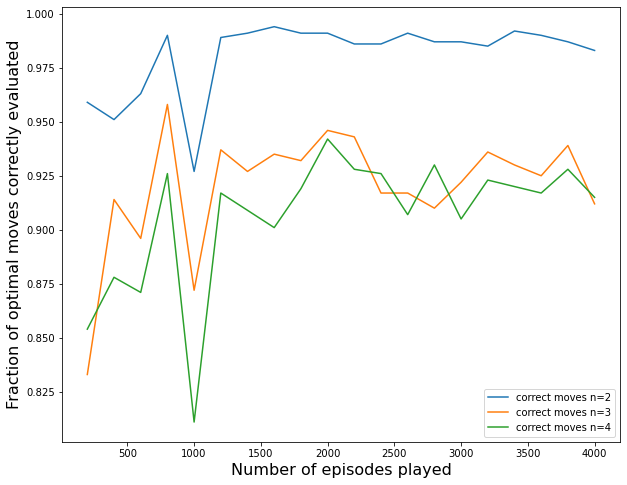

In [59]:
evolution_of_eval = np.array(evolution_of_eval)
plt.figure(figsize=(10,8))
plt.plot(checkpoints, evolution_of_eval[:,0], label="correct moves n=2")
plt.plot(checkpoints, evolution_of_eval[:,1], label="correct moves n=3")
plt.plot(checkpoints, evolution_of_eval[:,2], label="correct moves n=4")
plt.xlabel("Number of episodes played", fontsize=16)
plt.ylabel("Fraction of optimal moves correctly evaluated", fontsize=16)
plt.legend()
plt.show()

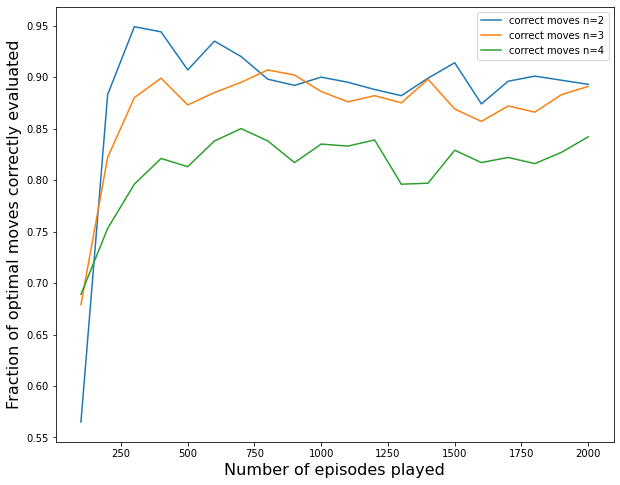

In [73]:
evolution_of_eval = np.array(evolution_of_eval)
plt.figure(figsize=(10,8))
plt.plot(checkpoints, evolution_of_eval[:,0], label="correct moves n=2")
plt.plot(checkpoints, evolution_of_eval[:,1], label="correct moves n=3")
plt.plot(checkpoints, evolution_of_eval[:,2], label="correct moves n=4")
plt.xlabel("Number of episodes played", fontsize=16)
plt.ylabel("Fraction of optimal moves correctly evaluated", fontsize=16)
plt.legend()
plt.show()

Once again, after more or less 300 epochs nothing more is learned.


In [60]:
def render_value_map_many_checkpoints(exp_id, checkpoints, frame_generator, scenario="first"):
    """
    Generate the same set of frames and evaluate it with value networks corresponding to different checkpoints.
    """
    cols = 5
    rows = len(checkpoints) // cols
    
    # frames equal for all checkpoints
    if scenario == "first":
        print("Yes item in inventory; only target monster on the map.")
        frames, target_pos, free_positions = agent_target_yes_item_in_inv_frames(frame_generator)
    elif scenario=="second":
        print("Empty inventory; only yes item and target monster on the map.")
        frames, target_pos, yes_pos, free_positions = agent_target_yes_item_to_collect_frames(frame_generator)
    elif scenario=="third":
        print("Yes item in inventory; target and distractor monsters on the map.")
        frames, target_pos, distractor_pos, free_positions = third_scenario_frames(frame_generator)
    elif scenario=="fourth":
        print("Empty inventory; yes item, target and distractor monsters on the map.")
        frames, target_pos, distractor_pos, yes_pos, free_positions = fourth_scenario_frames(frame_generator)
    elif scenario=="fifth":
        print("Empty inventory; every object present on the map.")
        frames, target_pos, distractor_pos, yes_pos, no_pos, free_positions = fifth_scenario_frames(frame_generator)
    else:
        raise Exception("Scenario not recognized.")
        
    plt.figure(figsize=(15,12))
    for i, c in enumerate(checkpoints):
        checkpoint="%d"%c
        training_dict = torch.load("save_dir/%s/training_dict_%s"%(exp_id,checkpoint))
        object_ids=training_dict["object_ids"]
        value_net=training_dict["value_net"]

        if i == 0:
            print("\nExample of frame:")
            render_frame(frames[0]["name"][0], object_ids)

        values = []
        for f in frames:
            with torch.no_grad():
                v = value_net(f).cpu().item()
                values.append(v)
        values = np.array(values)


        value_map = np.zeros(frame_generator.wall_mask.shape)
        for j, agent_pos in enumerate(free_positions):
            value_map[agent_pos[0],agent_pos[1]] = values[j]

        
        ax = plt.subplot2grid((rows, cols), (i//cols, i%cols))
        ax.imshow(value_map, cmap="copper", vmin=-0.1, vmax=1)
        ax.set_title("Checkpoint %s"%checkpoint)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

Yes item in inventory; only target monster on the map.

Example of frame:
██████
█!@  █
█    █
█    █
█    █
██████



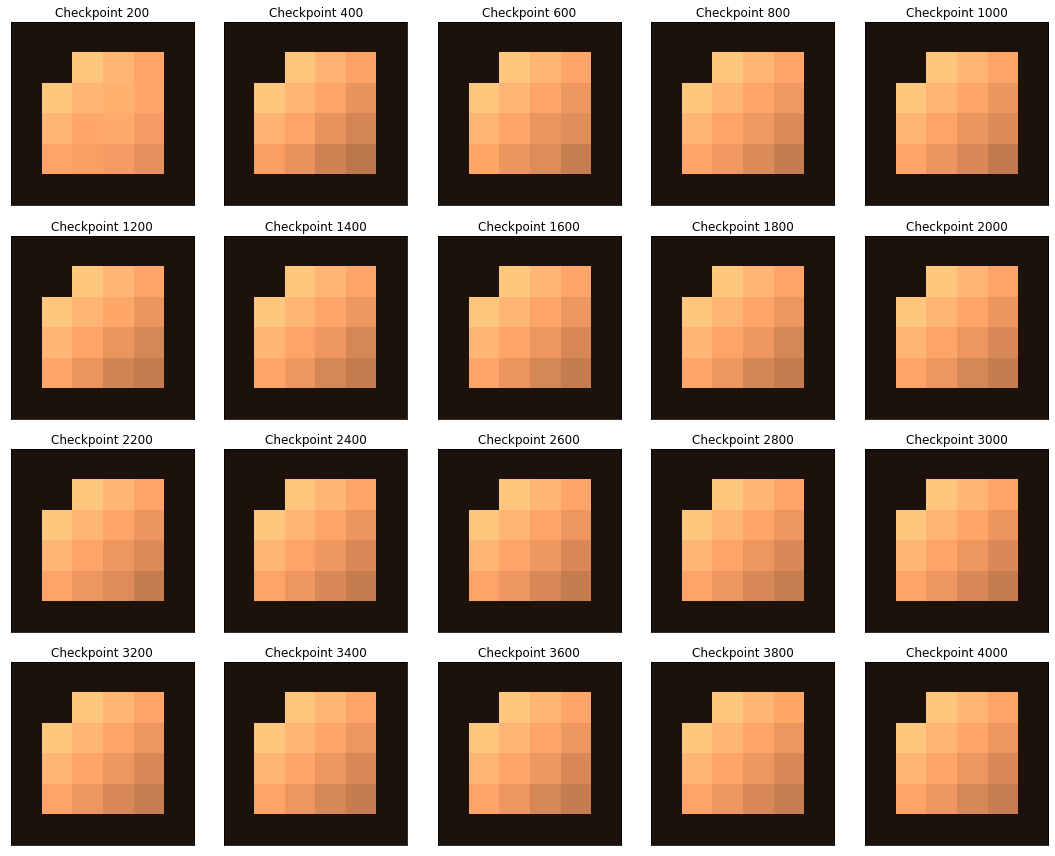

In [61]:
exp_id = "optimal_value_AAE"
checkpoints = np.arange(1,21)*200
render_value_map_many_checkpoints(exp_id, checkpoints, fg, scenario="first")

Empty inventory; only yes item and target monster on the map.

Example of frame:
██████
█y@  █
█ !  █
█    █
█    █
██████



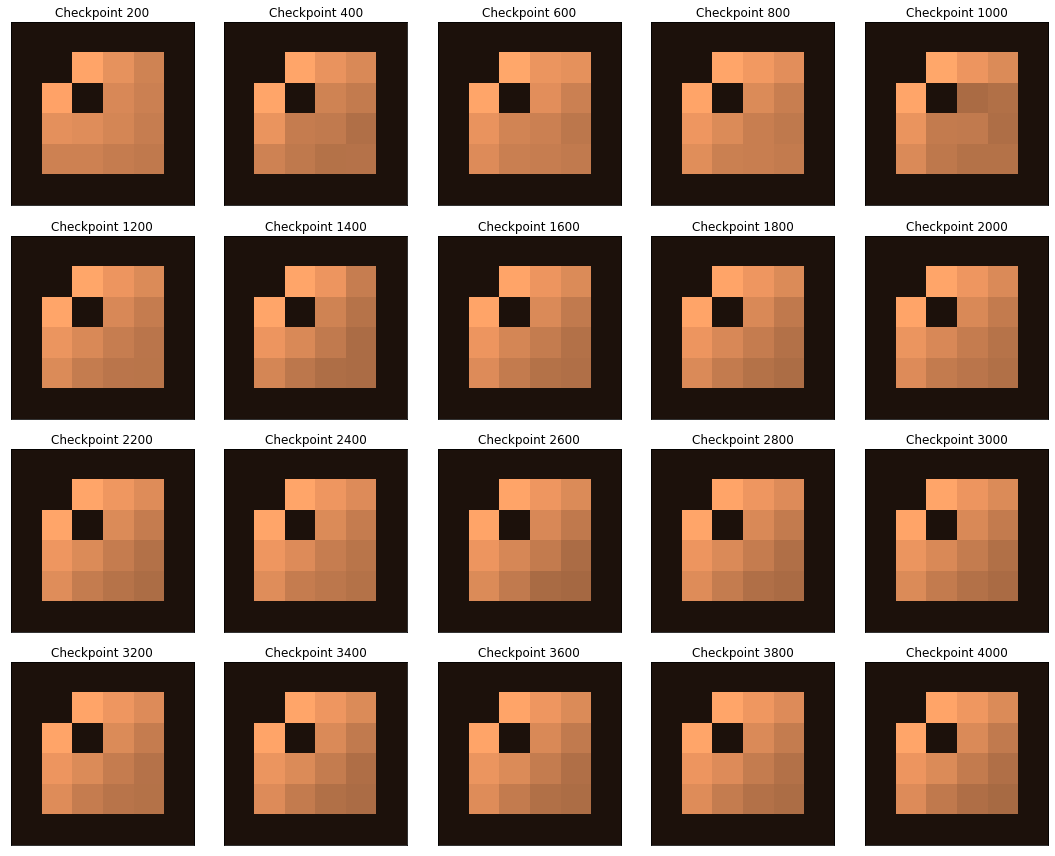

In [62]:
render_value_map_many_checkpoints(exp_id, checkpoints, fg, scenario="second")

Yes item in inventory; target and distractor monsters on the map.

Example of frame:
██████
█@ ? █
█ !  █
█    █
█    █
██████



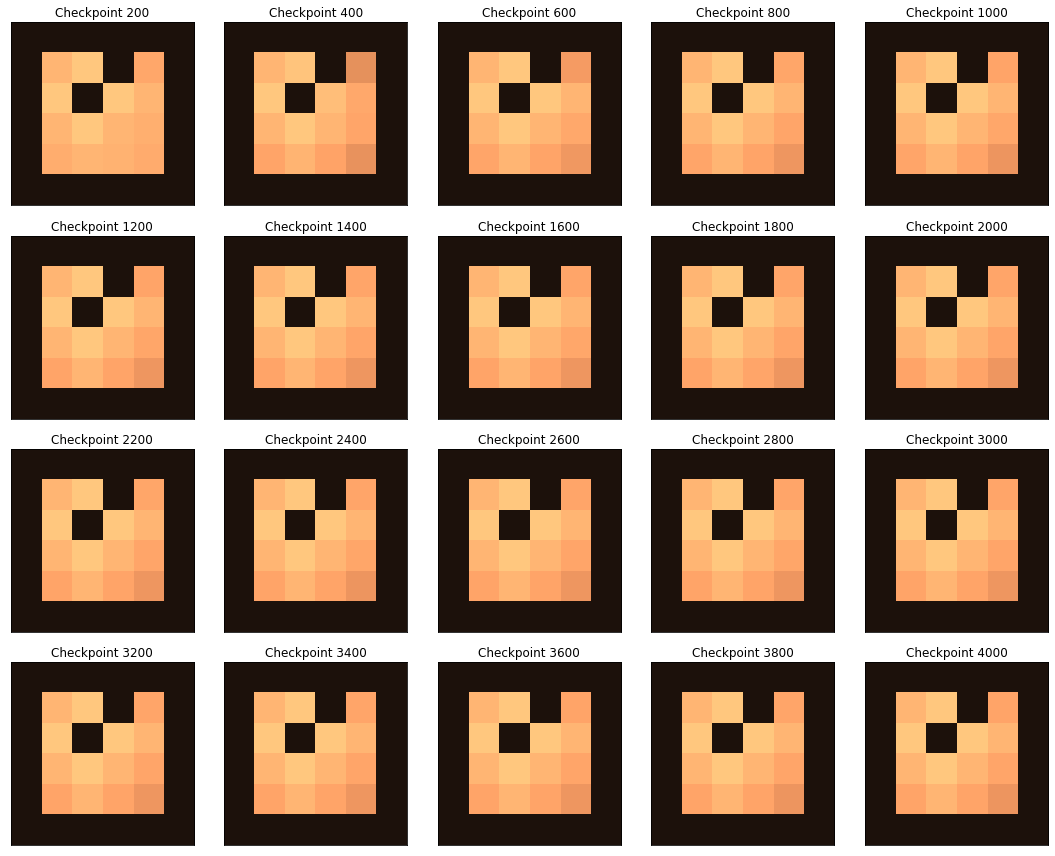

In [63]:
render_value_map_many_checkpoints(exp_id, checkpoints, fg, scenario="third")

Empty inventory; yes item, target and distractor monsters on the map.

Example of frame:
██████
█@   █
█    █
█    █
█?y! █
██████



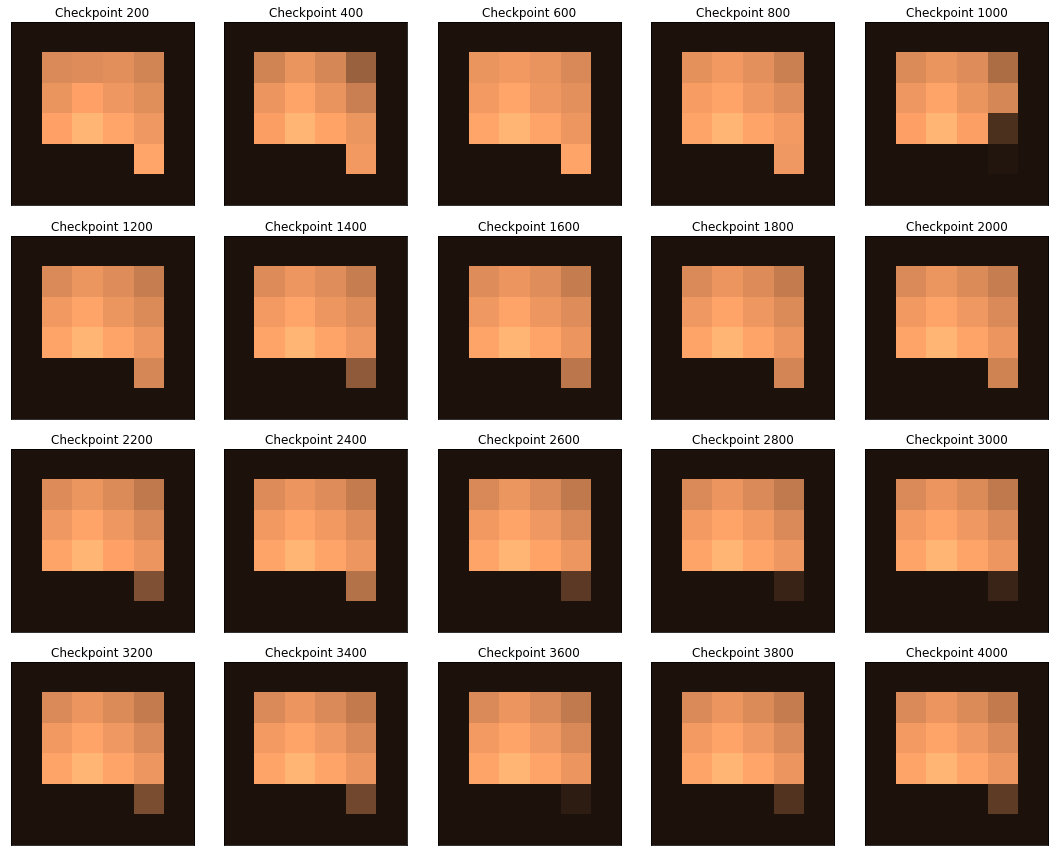

In [64]:
render_value_map_many_checkpoints(exp_id, checkpoints, fg, scenario="fourth")

Empty inventory; every object present on the map.

Example of frame:
██████
█@   █
█?n !█
█y   █
█    █
██████



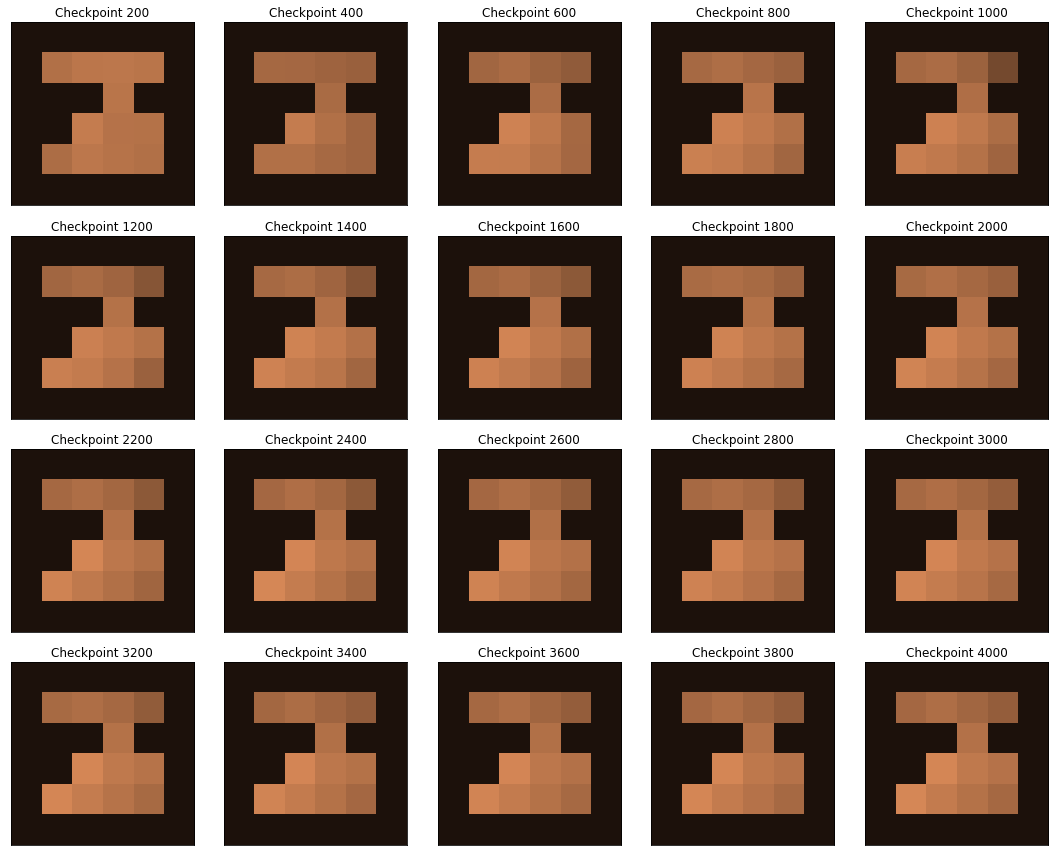

In [65]:
render_value_map_many_checkpoints(exp_id, checkpoints, fg, scenario="fifth")

### Using optimal policy and trajectories to analyze what is going on

To do that we need an environment simulator with the correct object ids. Unfortunately for some reason the items change between some possible values every time I create the environment from scratch, so at the moment I need to shut-down and restart the notebook until the new_object_ids are the same of the object_ids 

In [66]:
object_ids

{'target_monster': 179,
 'distractor_monster': 180,
 'agent': 183,
 'no_item': 201,
 'yes_item': 199}

In [67]:
new_object_ids = utils.get_object_ids_dict(game_simulator)
new_object_ids

{'target_monster': 179,
 'distractor_monster': 180,
 'agent': 183,
 'yes_item': 199,
 'no_item': 201}

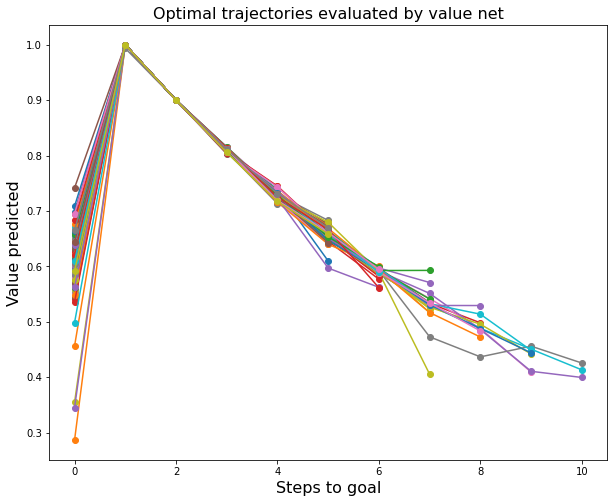

In [68]:
episode_length = 32 # max episode length, optimal trajectories should always be shorter
number_of_episodes = 100
problematic_trajectories = []

plt.figure(figsize=(10,8))
for i in range(number_of_episodes):
    total_reward, frame_lst = utils.play_episode_optimal_policy(
        game_simulator,
        episode_length,
        object_ids,
        render=False,
        return_frames=True
    )
    
    if total_reward == 1:
        value_net.eval()
        with torch.no_grad():
            values = [value_net(f).cpu().squeeze() for f in frame_lst]

        # check whether values are monotonically increasing or not (disregarding the terminal state, 
        # because in that case we should sum a reward of 1)    
        correct = True
        if len(values) > 2:
            for j in range(len(values)-2): # look at pairs (j,j+1), stop at one pair from the end
                if values[j] > values[j+1]:
                    correct = False
        if not correct:
            problematic_trajectories.append((frame_lst,values))

        plt.plot(np.arange(len(values)), values[::-1], "o-") # plot them from the last to the first
    
plt.xlabel("Steps to goal", fontsize=16)
plt.ylabel("Value predicted", fontsize=16)
plt.title("Optimal trajectories evaluated by value net", fontsize=16)
plt.show()

In [69]:
for traj, values in problematic_trajectories:
    print("\n","-"*40)
    for i, f in enumerate(traj[:-2]):
        utils.render_frame(f, object_ids)
        if values[i] > values[i+1]:
            print("Predicted value: %.3f (problematic) \n"%values[i])
        else:
            print("Predicted value: %.3f \n"%values[i])
    
    utils.render_frame(traj[-2], object_ids)
    print("Predicted value: %.3f \n"%values[-2])
    utils.render_frame(traj[-1], object_ids)
    print("Predicted value: %.3f \n"%values[-1])


 ----------------------------------------
██████
█y n █
█?   █
█   @█
█!   █
██████

Predicted value: 0.425 

██████
█y n █
█?   █
█  @ █
█!   █
██████

Predicted value: 0.456 (problematic) 

██████
█y n █
█?   █
█ @  █
█!   █
██████

Predicted value: 0.437 

██████
█y n █
█?@  █
█    █
█!   █
██████

Predicted value: 0.473 

██████
█y@n █
█?   █
█    █
█!   █
██████

Predicted value: 0.592 

██████
█@ n █
█?   █
█    █
█!   █
██████

Predicted value: 0.665 

██████
█ @n █
█?   █
█    █
█!   █
██████

Predicted value: 0.719 

██████
█  n █
█?@  █
█    █
█!   █
██████

Predicted value: 0.809 

██████
█  n █
█?   █
█ @  █
█!   █
██████

Predicted value: 0.900 

██████
█  n █
█?   █
█@   █
█!   █
██████

Predicted value: 1.000 

██████
█  n █
█?   █
█    █
█@   █
██████

Predicted value: 0.574 


 ----------------------------------------
██████
█ y  █
█    █
█@   █
█! n?█
██████

Predicted value: 0.593 (problematic) 

██████
█ y  █
█    █
█ @  █
█! n?█
██████

Predicted value: 0.592 

██

In [70]:
frac_of_problematic_traj = len(problematic_trajectories)/number_of_episodes
print("Percentage of problematic trajectories: %.1f %%"%(frac_of_problematic_traj*100))

Percentage of problematic trajectories: 2.0 %
